🤔 "어떤 가구가 사회 보장 지원 제도를 가장 먼저 받아야 할까?"
    
라틴 아메리카에서는 수입의 질을 평가하기 위해 **P**roxy **M**eans **T**est, 줄여서 PMT를 수행한다. 기관은 가족의 관찰 가능한 가정 속성(벽이나 천장의 재료, 가정에서 발견되는 자산)을 고려하여 분류하고, 사회 보장 지원 제도의 필요 수준을 예측하는 모델을 사용한다.

# 목표
주어진 `Id`에 대해 `Target`의 class를 예측하기

# 필요한 모듈 임포트

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from tqdm import tqdm
import featuretools as ft
import warnings 
warnings.filterwarnings('ignore')
import time

# 데이터 확인

In [2]:
train = pd.read_csv('../../week04/Eunhee/input/train.csv')
test = pd.read_csv('../../week04/Eunhee/input/test.csv')

In [3]:
print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


## Target 변수의 분포 확인하기

Text(0.5, 1.0, 'Distribtion of income levels')

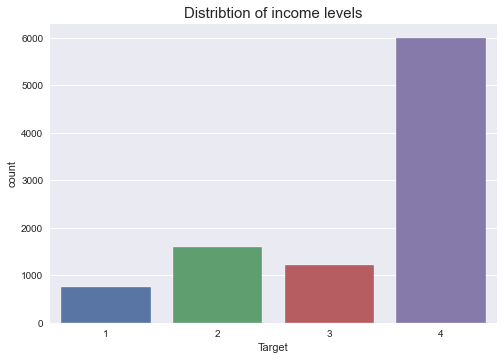

In [4]:
sns.countplot(x='Target', data=train)
plt.title('Distribtion of income levels', fontsize=15)

수입 수준은 ordinal variable로, 각각 다음을 나타낸다.
- 1 : 극빈곤
- 2 : 중간 수준의 빈곤
- 3 : 취약 가구
- 4 : 취약하지 않은 가구

In [5]:
print("Target 1 (extreme poverty) : %.2f" %(sum(train['Target'] == 1) / len(train['Target']) * 100) + "%")
print("Target 2 (moderate poverty) : %.2f" %(sum(train['Target'] == 2) / len(train['Target']) * 100) + "%")
print("Target 3 (vulnerable households) : %.2f" %(sum(train['Target'] == 3) / len(train['Target']) * 100) + "%")
print("Target 4 (non vulnerable households) : %.2f" %(sum(train['Target'] == 4) / len(train['Target']) * 100) + "%")

Target 1 (extreme poverty) : 7.90%
Target 2 (moderate poverty) : 16.71%
Target 3 (vulnerable households) : 12.65%
Target 4 (non vulnerable households) : 62.74%


## 결측치 확인

In [6]:
train.isnull().sum().sort_values(ascending=False).head(5)

rez_esc      7928
v18q1        7342
v2a1         6860
SQBmeaned       5
meaneduc        5
dtype: int64

In [7]:
test.isnull().sum().sort_values(ascending=False).head(5)

rez_esc      19653
v18q1        18126
v2a1         17403
meaneduc        31
SQBmeaned       31
dtype: int64

In [8]:
# if education is "yes" and person is head of household, fill with escolari
train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "edjefa"] = train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "escolari"]
train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "edjefe"] = train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "escolari"]

test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "edjefa"] = test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "escolari"]
test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "edjefe"] = test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what "yes" means, let's fill it with 4
train.loc[train['edjefa'] == "yes", "edjefa"] = 4
train.loc[train['edjefe'] == "yes", "edjefe"] = 4

test.loc[test['edjefa'] == "yes", "edjefa"] = 4
test.loc[test['edjefe'] == "yes", "edjefe"] = 4

# create feature with max education of either head of household
train['edjef'] = np.max(train[['edjefa','edjefe']], axis=1)
test['edjef'] = np.max(test[['edjefa','edjefe']], axis=1)

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet, 
# if there is no water we'll assume they do not
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "v14a"] = 0
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "sanitario1"] = 0

test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "v14a"] = 0
test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "sanitario1"] = 0

- `rez_esc` : Years behind in school

In [9]:
train['rez_esc'].fillna(0, inplace=True)
test['rez_esc'].fillna(0, inplace=True)

- `SQBmeaned` : Square of the mean years of education of adults (>= 18) in the household

In [10]:
train['SQBmeaned'].fillna(0, inplace=True)
test['SQBmeaned'].fillna(0, inplace=True)

- `meaneduc` : Average years of education for adults (+18)

In [11]:
train['meaneduc'].fillna(0, inplace=True)
test['meaneduc'].fillna(0, inplace=True)

- `v18q1` : Number of tablets household owns

In [12]:
train['v18q1'].fillna(0, inplace=True)
test['v18q1'].fillna(0, inplace=True)

- `v2a1` : Monthly rent payment

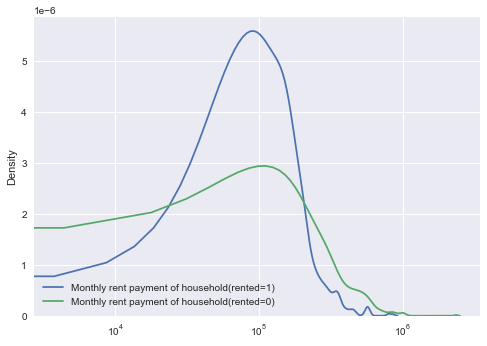

In [13]:
sns.kdeplot(train.loc[train['tipovivi3'] == 1, 'v2a1'], label='Monthly rent payment of household(rented=1)')
sns.kdeplot(train.loc[train['tipovivi3'] == 0, 'v2a1'], label='Monthly rent payment of household(rented=0)')
plt.xscale('log')
plt.xlabel('')
plt.legend()
plt.show()

In [14]:
train['v2a1'].fillna(0, inplace=True)
test['v2a1'].fillna(0, inplace=True)

# Feature engineering

## Object features

**dependency** : dependency rate

In [15]:
features_object = [col for col in train.columns if train[col].dtype == 'object']

In [16]:
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

In [17]:
train['dependency'].head()

0     no
1      8
2      8
3    yes
4    yes
Name: dependency, dtype: object

In [18]:
train['SQBdependency'].head()

0     0.0
1    64.0
2    64.0
3     1.0
4     1.0
Name: SQBdependency, dtype: float64

몇몇 `dependency`가 `NA`이기 때문에, `SQBdependency`의 제곱근값으로 대체한다.

In [19]:
train['dependency'] = np.sqrt(train['SQBdependency'])
test['dependency'] = np.sqrt(test['SQBdependency'])

**edjefe** : years of education of male head of household (yes → 1, no → 0 으로 대체)

In [20]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

train['edjefe'] = train['edjefe'].apply(replace_edjefe).astype(float)
test['edjefe'] = test['edjefe'].apply(replace_edjefe).astype(float)

**edjefa** : years of education of female head of household (yes → 1, no → 0 으로 대체)

In [21]:
def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

train['edjefa'] = train['edjefa'].apply(replace_edjefa).astype(float)
test['edjefa'] = test['edjefa'].apply(replace_edjefa).astype(float)

**edjef** : max education of either head(male or female) of household

In [22]:
train['edjef'] = np.max(train[['edjefa', 'edjefe']], axis=1)
test['edjef'] = np.max(test[['edjefa', 'edjefe']], axis=1)

**roof and electricity**

In [23]:
train['roof_waste_material'] = np.nan
test['roof_waste_material'] = np.nan
train['electricity_other'] = np.nan
test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0

train['roof_waste_material'] = train.apply(lambda x : fill_roof_exception(x),axis=1)
test['roof_waste_material'] = test.apply(lambda x : fill_roof_exception(x),axis=1)
train['electricity_other'] = train.apply(lambda x : fill_no_electricity(x),axis=1)
test['electricity_other'] = test.apply(lambda x : fill_no_electricity(x),axis=1)

## Extract category features

In [24]:
binary_cat_featuers = [col for col in train.columns if train[col].value_counts().shape[0] == 2]

In [25]:
print('There are %.f category featurs' %(len(binary_cat_featuers)))

There are 103 category featurs


## Make new features using continous features

In [26]:
continuous_features = [col for col in train.columns if col not in binary_cat_featuers]
continuous_features = [col for col in continuous_features if col not in features_object]
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target', 'idhogar']]

In [27]:
print('There are %.f continuous featurs' %(len(continuous_features)))

There are 37 continuous featurs


- `hhsize` : household size
- `tamhog` : size of the household

설명상 둘은 같은 것을 지칭하므로, `tamhog`을 drop한다.

In [28]:
train.drop('tamhog', axis=1, inplace=True)
test.drop('tamhog', axis=1, inplace=True)

**Family features**

🤔 `hogar_total`과 `r4t3`의 차이는 무엇일까?

In [29]:
sum(train['hogar_total'] == train['r4t3']) / len(train) * 100

99.49775034006487

**Family size features**

- `hogar_adul` : Number of adults in household
- `hogar_mayor` : # of individuals 65+ in the household
- `hogar_nin` : Number of children 0 to 19 in household
- `hogar_total` : # of total individuals in the household
- `r4h1` : Males younger than 12 years of age
- `r4h2` : Males 12 years of age and older
- `r4h3` : Total males in the household
- `r4m1` : Females younger than 12 years of age
- `r4m2` : Females 12 years of age and older
- `r4m3` : Total females in the household
- `r4t1` : persons younger than 12 years of age
- `r4t2` : persons 12 years of age and older
- `r4t3` : Total persons in the household

In [30]:
train['adult'] = train['hogar_adul'] - train['hogar_mayor']

train['dependency_count'] = train['hogar_nin'] + train['hogar_mayor']
train['dependency'] = train['dependency_count'] / train['adult']

train['child_percent'] = train['hogar_nin'] / train['hogar_total']
train['elder_percent'] = train['hogar_mayor'] / train['hogar_total']
train['adult_percent'] = train['hogar_adul'] / train['hogar_total']

train['males_younger_12_years_percent'] = train['r4h1'] / train['hogar_total']
train['males_older_12_years_percent'] = train['r4h2'] / train['hogar_total']
train['males_percent'] = train['r4h3'] / train['hogar_total']

train['females_younger_12_years_percent'] = train['r4m1'] / train['hogar_total']
train['females_older_12_years_percent'] = train['r4m2'] / train['hogar_total']
train['females_percent'] = train['r4m3'] / train['hogar_total']

train['persons_younger_12_years_percent'] = train['r4t1'] / train['hogar_total']
train['persons_older_12_years_percent'] = train['r4t2'] / train['hogar_total']
train['persons_percent'] = train['r4t3'] / train['hogar_total']

In [31]:
test['adult'] = test['hogar_adul'] - test['hogar_mayor']

test['dependency_count'] = test['hogar_nin'] + test['hogar_mayor']
test['dependency'] = test['dependency_count'] / test['adult']

test['child_percent'] = test['hogar_nin'] / test['hogar_total']
test['elder_percent'] = test['hogar_mayor'] / test['hogar_total']
test['adult_percent'] = test['hogar_adul'] / test['hogar_total']

test['males_younger_12_years_percent'] = test['r4h1'] / test['hogar_total']
test['males_older_12_years_percent'] = test['r4h2'] / test['hogar_total']
test['males_percent'] = train['r4h3'] / test['hogar_total']

test['females_younger_12_years_percent'] = test['r4m1'] / test['hogar_total']
test['females_older_12_years_percent'] = test['r4m2'] / test['hogar_total']
test['females_percent'] = test['r4m3'] / test['hogar_total']

test['persons_younger_12_years_percent'] = test['r4t1'] / test['hogar_total']
test['persons_older_12_years_percent'] = test['r4t2'] / test['hogar_total']
test['persons_percent'] = test['r4t3'] / test['hogar_total']

In [32]:
train['males_younger_12_years_in_household_size'] = train['r4h1'] / train['hhsize']
train['males_older_12_years_in_household_size'] = train['r4h2'] / train['hhsize']
train['males_in_household_size'] = train['r4h3'] / train['hhsize']
train['females_younger_12_years_in_household_size'] = train['r4m1'] / train['hhsize']
train['females_older_12_years_in_household_size'] = train['r4m2'] / train['hhsize']
train['females_in_household_size'] = train['r4m3'] / train['hogar_total']
train['persons_younger_12_years_in_household_size'] = train['r4t1'] / train['hhsize']
train['persons_older_12_years_in_household_size'] = train['r4t2'] / train['hhsize']
train['persons_in_household_size'] = train['r4t3'] / train['hhsize']

In [33]:
test['males_younger_12_years_in_household_size'] = test['r4h1'] / test['hhsize']
test['males_older_12_years_in_household_size'] = test['r4h2'] / test['hhsize']
test['males_in_household_size'] = test['r4h3'] / test['hhsize']
test['females_younger_12_years_in_household_size'] = test['r4m1'] / test['hhsize']
test['females_older_12_years_in_household_size'] = test['r4m2'] / test['hhsize']
test['females_in_household_size'] = test['r4m3'] / test['hogar_total']
test['persons_younger_12_years_in_household_size'] = test['r4t1'] / test['hhsize']
test['persons_older_12_years_in_household_size'] = test['r4t2'] / test['hhsize']
test['persons_in_household_size'] = test['r4t3'] / test['hhsize']

In [34]:
train['overcrowding_room_and_bedroom'] = (train['hacdor'] + train['hacapo'])/2
test['overcrowding_room_and_bedroom'] = (test['hacdor'] + test['hacapo'])/2

- `escolari` : years of schooling

In [35]:
train['escolari_age'] = train['escolari'] / train['age']
test['escolari_age'] = test['escolari'] / test['age']

train['age_12_19'] = train['hogar_nin'] - train['r4t1']
test['age_12_19'] = test['hogar_nin'] - test['r4t1']  

- `v18q1` : number of tablets household owns
- `v2a1` : Monthly rent payment

In [36]:
train['phones-per-capita'] = train['qmobilephone'] / train['tamviv']
train['tablets-per-capita'] = train['v18q1'] / train['tamviv']
train['rooms-per-capita'] = train['rooms'] / train['tamviv']
train['rent-per-capita'] = train['v2a1'] / train['tamviv']

In [37]:
test['phones-per-capita'] = test['qmobilephone'] / test['tamviv']
test['tablets-per-capita'] = test['v18q1'] / test['tamviv']
test['rooms-per-capita'] = test['rooms'] / test['tamviv']
test['rent-per-capita'] = test['v2a1'] / test['tamviv']

**Room per family features**

In [38]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per{}'.format('v2a1', col)
    new_feats.append(new_col_name)
    train[new_col_name] = train['v2a1'] / train[col]
    test[new_col_name] = test['v2a1'] / test[col]

비율 feature은 무한의 값을 가질 수 있는데, 이런 값들은 `NaN`으로 만든 뒤, 0으로 채워질 수 있도록 한다.

In [39]:
for col in new_feats:
    train[col].replace([np.inf], np.nan, inplace=True)
    train[col].fillna(0, inplace=True)
    test[col].replace([np.inf], np.nan, inplace=True)
    test[col].fillna(0, inplace=True)

**Room per family features**

In [40]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name)
    train[new_col_name] = train['rooms'] / train[col]
    test[new_col_name] = test['rooms'] / test[col]

In [41]:
for col in new_feats:
    train[col].replace([np.inf], np.nan, inplace=True)
    train[col].fillna(0, inplace=True)
    test[col].replace([np.inf], np.nan, inplace=True)
    test[col].fillna(0, inplace=True)

**Bedroom per family features**

In [42]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('bedrooms', col)
    new_feats.append(new_col_name)
    train[new_col_name] = train['bedrooms'] / train[col]
    test[new_col_name] = test['bedrooms'] / test[col]

In [43]:
for col in new_feats:
    train[col].replace([np.inf], np.nan, inplace=True)
    train[col].fillna(0, inplace=True)
    test[col].replace([np.inf], np.nan, inplace=True)
    test[col].fillna(0, inplace=True)

**Tablet per family features**

In [44]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v18q1', col)
    new_feats.append(new_col_name)
    train[new_col_name] = train['v18q1'] / train[col]
    test[new_col_name] = test['v18q1'] / test[col]

for col in new_feats:
    train[col].replace([np.inf], np.nan, inplace=True)
    train[col].fillna(0, inplace=True)
    
    test[col].replace([np.inf], np.nan, inplace=True)
    test[col].fillna(0, inplace=True)

**Phone per family features**

In [45]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('qmobilephone', col)
    new_feats.append(new_col_name)
    train[new_col_name] = train['qmobilephone'] / train[col]
    test[new_col_name] = test['qmobilephone'] / test[col]

for col in new_feats:
    train[col].replace([np.inf], np.nan, inplace=True)
    train[col].fillna(0, inplace=True)
    
    test[col].replace([np.inf], np.nan, inplace=True)
    test[col].fillna(0, inplace=True)

**Years behind in school per family features**

In [46]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rez_esc', col)
    new_feats.append(new_col_name)
    train[new_col_name] = train['rez_esc'] / train[col]
    test[new_col_name] = test['rez_esc'] / test[col]

for col in new_feats:
    train[col].replace([np.inf], np.nan, inplace=True)
    train[col].fillna(0, inplace=True)
    
    test[col].replace([np.inf], np.nan, inplace=True)
    test[col].fillna(0, inplace=True)

In [47]:
train['rez_esc_age'] = train['rez_esc'] / train['age']
train['rez_esc_escolari'] = train['rez_esc'] / train['escolari']

test['rez_esc_age'] = test['rez_esc'] / test['age']
test['rez_esc_escolari'] = test['rez_esc'] / test['escolari']

**Rich features**
- 부자일 수록 더 많은 휴대전화와 태블릿을 소유할 것이다

In [48]:
train['tablet_x_qmobilephone'] = train['v18q1'] * train['qmobilephone']
test['tablet_x_qmobilephone'] = test['v18q1'] * test['qmobilephone']

- wall, roof, floor
    - `epared1` : =1 if walls are bad
    - `epared2` : =2 if walls are regular
    - `epared3` : =3 if walls are good
    - `etecho1` : =1 if the roof are bad
    - `etecho2` : =2 if the roof are regular
    - `etecho3` : =3 if the roof are good
    - `eviv1` : =1 if the floor are bad
    - `eviv2` : =2 if the floor are regular
    - `eviv3` : =3 if the floor are good

In [49]:
# Wall and roof
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]

# Wall and floor
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]

# Roof and floor
for col1 in ['etecho1', 'etecho2', 'etecho3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]

In [50]:
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        for col3 in ['eviv1', 'eviv2', 'eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            train[new_col_name] = train[col1] * train[col2] * train[col3]
            test[new_col_name] = test[col1] * test[col2] * test[col3]

- 전기, 에너지 feature를 에너지 feature로 합치기

In [51]:
for col1 in ['public', 'planpri', 'noelec', 'coopele']:
    for col2 in ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]

- 화장실, 쓰레기 처리 feature를 기타 인프라 feature로 합치기

In [52]:
for col1 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]

- 화장실, 수도 공급 feature를 water feature로 합치기

In [53]:
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]

- 교육, 지역(area) feature를 교육 지역 feature로 합치기

In [54]:
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]

- 구역(region), 교육 feature를 합치기

In [55]:
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]

- 텔레비전, 휴대전화, 컴퓨터, 태블릿, 냉장고 feature를 전자제품 feature로 합치기

In [56]:
train['electronics'] = train['computer'] * train['mobilephone'] * train['television'] * train['v18q'] * train['refrig']
test['electronics'] = test['computer'] * test['mobilephone'] * test['television'] * test['v18q'] * test['refrig']

train['no_appliances'] = train['refrig'] + train['computer'] + train['television'] + train['mobilephone']
test['no_appliances'] = test['refrig'] + test['computer'] + test['television'] + test['mobilephone']

- roof, floor, wall의 재료 feature들 합치기

In [57]:
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]

for col1 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
    for col1 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        train[new_col_name] = train[col1] * train[col2]
        test[new_col_name] = test[col1] * test[col2]        
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        for col3 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            train[new_col_name] = train[col1] * train[col2] * train[col3]
            test[new_col_name] = test[col1] * test[col2] * train[col3]

## 하나의 값만 가지고 있는 feature들 삭제

In [58]:
cols_with_only_one_values = []
for col in train.columns:
    if col == 'Target':
        continue
    if train[col].value_counts().shape[0] == 1 or test[col].value_counts().shape[0] == 1:
        #print(col)
        cols_with_only_one_values.append(col)

In [59]:
len(cols_with_only_one_values)

217

In [60]:
train.drop(cols_with_only_one_values, axis=1, inplace=True)
test.drop(cols_with_only_one_values, axis=1, inplace=True)

Train set과 test set이 같은 feature들을 가지고 있는지 확인한다.

In [61]:
[col for col in train.columns if col != 'Target'] == [col for col in test.columns]

True

## `idhogar`를 기준으로 변수 집계하기

In [62]:
def max_min(x):
    return x.max() - x.min()

In [63]:
agg_train = pd.DataFrame()
agg_test = pd.DataFrame()

for item in tqdm(family_size_features):
    for i, function in enumerate(['mean', 'std', 'min', 'max', 'sum', 'count', max_min]):
        group_train = train[item].groupby(train['idhogar']).agg(function)
        group_test = test[item].groupby(test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new_' + 'max_min'
        else:
            new_col = item + '_new_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test


print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 15/15 [00:06<00:00,  2.25it/s]

new aggregate train set has 2988 rows, and 105 features
new aggregate test set has 7352 rows, and 105 features


In [64]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']


for item in tqdm(aggr_list):
    for function in ['count', 'sum']:
        group_train = train[item].groupby(train['idhogar']).agg(function)
        group_test = test[item].groupby(test['idhogar']).agg(function)
        new_col = item + '_new1_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 47/47 [00:00<00:00, 91.35it/s]

new aggregate train set has 2988 rows, and 199 features
new aggregate test set has 7352 rows, and 199 features


In [65]:
aggr_list = ['escolari', 'age', 'escolari_age', 'dependency', 'bedrooms', 'overcrowding', 'rooms', 'qmobilephone', 'v18q1']

for item in tqdm(aggr_list):
    for function in ['mean','std','min','max','sum', 'count', max_min]:
        group_train = train[item].groupby(train['idhogar']).agg(function)
        group_test = test[item].groupby(test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new2_' + 'max_min'
        else:
            new_col = item + '_new2_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 9/9 [00:04<00:00,  2.10it/s]

new aggregate train set has 2988 rows, and 208 features
new aggregate test set has 7352 rows, and 208 features


In [66]:
agg_train = agg_train.reset_index()
agg_test = agg_test.reset_index()

train_agg = pd.merge(train, agg_train, on='idhogar')
test = pd.merge(test, agg_test, on='idhogar')

#fill all na as 0
train_agg.fillna(0, inplace=True)
test.fillna(0, inplace=True)

print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 724) test shape: (23856, 723)


In [67]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1006) test shape: (23856, 1005)


In [68]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1288) test shape: (23856, 1287)


In [69]:
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

for function in tqdm(['mean','std','min','max','sum', 'count', max_min]):
    for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
        group_train = train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_train.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_train][2:]

        group_test = test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_test.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_test][2:]

        train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
        test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
        
print('train shape:', train_agg.shape, 'test shape:', test.shape)

100%|██████████| 7/7 [07:19<00:00, 62.74s/it]

train shape: (9557, 3262) test shape: (23856, 3261)


In [71]:
train = train_agg.query('parentesco1==1')

In [74]:
train['dependency'].replace(np.inf, 0, inplace=True)
test['dependency'].replace(np.inf, 0, inplace=True)

In [75]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['idhogar','Id', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id',  'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)

In [77]:
print('final data size : ', train.shape, test.shape)

final data size :  (2973, 3250) (23856, 3249)


In [81]:
print(f'The most 20 positive feature : \n {correlation.head(20)}')

The most 20 positive feature : 
 Target                            1.000000
new5_lugar3_idhogar_edjef_max     0.334254
new5_lugar2_idhogar_edjef_max     0.334254
new5_lugar5_idhogar_edjef_max     0.334254
new5_lugar4_idhogar_edjef_max     0.334254
new5_lugar6_idhogar_edjef_max     0.334254
new5_lugar1_idhogar_edjef_max     0.334254
new5_lugar2_idhogar_edjef_mean    0.333873
new5_lugar4_idhogar_edjef_mean    0.333873
new5_lugar3_idhogar_edjef_mean    0.333873
new5_lugar1_idhogar_edjef_mean    0.333873
new5_lugar5_idhogar_edjef_mean    0.333873
new5_lugar6_idhogar_edjef_mean    0.333873
new5_lugar3_idhogar_edjef_min     0.333791
new5_lugar4_idhogar_edjef_min     0.333791
new5_lugar5_idhogar_edjef_min     0.333791
new5_lugar6_idhogar_edjef_min     0.333791
edjef                             0.333791
new5_lugar2_idhogar_edjef_min     0.333791
new5_lugar1_idhogar_edjef_min     0.333791
Name: Target, dtype: float64


In [86]:
print(f'The most 20 positive feature : \n {correlation.tail(20)}')

The most 20 positive feature : 
 new5_lugar5_idhogar_television_<function max_min at 0x000001B7004D4820>    NaN
new5_lugar5_idhogar_mobilephone_<function max_min at 0x000001B7004D4820>   NaN
new5_lugar5_idhogar_area1_<function max_min at 0x000001B7004D4820>         NaN
new5_lugar5_idhogar_area2_<function max_min at 0x000001B7004D4820>         NaN
new5_lugar5_idhogar_v18q_<function max_min at 0x000001B7004D4820>          NaN
new5_lugar6_idhogar_epared1_<function max_min at 0x000001B7004D4820>       NaN
new5_lugar6_idhogar_epared2_<function max_min at 0x000001B7004D4820>       NaN
new5_lugar6_idhogar_epared3_<function max_min at 0x000001B7004D4820>       NaN
new5_lugar6_idhogar_etecho1_<function max_min at 0x000001B7004D4820>       NaN
new5_lugar6_idhogar_etecho2_<function max_min at 0x000001B7004D4820>       NaN
new5_lugar6_idhogar_etecho3_<function max_min at 0x000001B7004D4820>       NaN
new5_lugar6_idhogar_eviv1_<function max_min at 0x000001B7004D4820>         NaN
new5_lugar6_idhogar